In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time as timer
import pickle

Input_File = 'ChangeDataset622v1.pickle'

def ReadPickle(filename: str) -> dict:
  '''Reads in data from given pickle files, outputs a dictionary'''
  try:
    Data = pd.read_pickle(filename)
  except FileNotFoundError:
    raise FileNotFoundError(f'Error reading {filename}')
  return Data

print(f"Loading Dataset -- '{Input_File}'")
t_Load1a = timer.time()
Data = ReadPickle(Input_File)
t_Load2a = timer.time()
print(f"Dataset took {round(t_Load2a-t_Load1a,2)}s to load")

D_data = np.array([np.tile(sample['Diffusion'],(1000,1)) for sample in Data])
V_data = np.array([np.tile(sample['Convection'],(1000,1)) for sample in Data])
R_data = np.array([np.tile(sample['Rho'],(1000,1)) for sample in Data])
T_data = np.array([np.tile(sample['Time'],(50, 1)).T for sample in Data])
N_data = np.array([Sample['Density'] for Sample in Data])
S_data = np.array([Sample['Source'].T for Sample in Data])
Database = np.array([np.array([D_data[i],V_data[i],R_data[i],T_data[i],N_data[i],S_data[i]]) for i in range(len(Data))])
print(Database.shape)

c:\Users\jslon\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Loading Dataset -- 'ChangeDataset622v1.pickle'
Dataset took 1.17s to load
(1000, 6, 1000, 50)


In [4]:
#This i will code myself later, had gpt code up a basic scaler to use for testing now

#############################GPT CODE FOR SCALING##############################

import numpy as np

# Assume Database is loaded with shape (1000, 6, 1000, 50)
print("Original shape:", Database.shape)

# Prepare an empty array to hold the standardized data
Database_channel_standardized = np.empty_like(Database)

# Loop over each channel to standardize it independently.
# Here axis=(0, 2, 3) computes statistics across all samples and the 2D dimensions for the given channel.
for c in range(Database.shape[1]):
    channel_data = Database[:, c, :, :]
    channel_mean = np.mean(channel_data)
    channel_std = np.std(channel_data)
    print(f"Channel {c}: mean = {channel_mean:.4f}, std = {channel_std:.4f}")
    
    Database_channel_standardized[:, c, :, :] = (channel_data - channel_mean) / channel_std

# Optionally, verify the results for one channel:
print("Channel 4 after standardization: mean = {:.4f}, std = {:.4f}".format(
    np.mean(Database_channel_standardized[:, 4, :, :]),
    np.std(Database_channel_standardized[:, 4, :, :])
))

#############################GPT CODE FOR SCALING##############################

Original shape: (1000, 6, 1000, 50)
Channel 0: mean = 0.9139, std = 0.5197
Channel 1: mean = 0.1455, std = 0.9727
Channel 2: mean = 0.5500, std = 0.3240
Channel 3: mean = 3.4500, std = 0.3179
Channel 4: mean = 37587480760498192384.0000, std = 26376029163218866176.0000
Channel 5: mean = 7438569513106123776.0000, std = 16713426982899210240.0000
Channel 4 after standardization: mean = 0.0000, std = 1.0000


In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Convolutional Variational Autoencoder:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim=640):
        super(VariationalAutoencoder, self).__init__()
        
        # Encoder:
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=2, padding=1),# -> (12, 500, 25)
            nn.SELU(),
            nn.Conv2d(12, 24, kernel_size=3, stride=2, padding=1),# -> (24, 250, 13)
            nn.SELU(),
            nn.Conv2d(24, 48, kernel_size=3, stride=2, padding=1),# -> (48, 125, 7)
            nn.SELU(),
            nn.Conv2d(48, 96, kernel_size=3, stride=2, padding=1),# -> (96, 63, 4)
            nn.SELU()
        )
        
        #Flattened conv feature size is 96*63*4 = 24192
        self.fc1 = nn.Linear(96*63*4,128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        
        #Decoder:
        self.decoder_fc = nn.Linear(latent_dim, 96*63*4)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(96, 48, kernel_size=3, stride=2, padding=1, output_padding=0),# -> (48, 125, 7)
            nn.SELU(),
            nn.ConvTranspose2d(48, 24, kernel_size=3, stride=2, padding=1, output_padding=(1, 0)),# -> (24, 250, 13)
            nn.SELU(),
            nn.ConvTranspose2d(24, 12, kernel_size=3, stride=2, padding=1, output_padding=(1, 0)),# -> (12, 500, 25)
            nn.SELU(),
            nn.ConvTranspose2d(12, 6, kernel_size=3, stride=2, padding=1, output_padding=(1, 1))# -> (6, 1000, 50)
        )
    
    def encode(self, x):
        x = self.encoder_conv(x)
        x = x.view(x.size(0),-1)
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        x = self.decoder_fc(z)
        x = x.view(-1,96,63,4)
        x = self.decoder_conv(x)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        decoded = self.decode(z)
        return decoded, mu, logvar

#Updated Loss Function using Mean Squared Error (MSE)
def vae_loss(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='mean')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

#Custom Dataset to handle the numerical array
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
        
    def __len__(self):
        return self.data.size(0)
    
    def __getitem__(self, idx):
        return self.data[idx], 0

dataset = CustomDataset(Database_channel_standardized)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

#Training Setup
latent_dim = 640
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VariationalAutoencoder(latent_dim=640).to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.0001)

#Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_data, _ in dataloader:
        batch_data = batch_data.to(device)
        decoded_data, mu, logvar = vae(batch_data)
        
        loss = vae_loss(decoded_data, batch_data, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")
    
print("Training complete!")


Epoch [1/100], Average Loss: 1.2484
Epoch [2/100], Average Loss: 1.0597
Epoch [3/100], Average Loss: 0.9427
Epoch [4/100], Average Loss: 0.8341
Epoch [5/100], Average Loss: 0.7341
Epoch [6/100], Average Loss: 0.6429
Epoch [7/100], Average Loss: 0.5603
Epoch [8/100], Average Loss: 0.4846
Epoch [9/100], Average Loss: 0.4168
Epoch [10/100], Average Loss: 0.3560
Epoch [11/100], Average Loss: 0.3016
Epoch [12/100], Average Loss: 0.2524
Epoch [13/100], Average Loss: 0.2090
Epoch [14/100], Average Loss: 0.1707
Epoch [15/100], Average Loss: 0.1375
Epoch [16/100], Average Loss: 0.1084
Epoch [17/100], Average Loss: 0.0844
Epoch [18/100], Average Loss: 0.0642
Epoch [19/100], Average Loss: 0.0481
Epoch [20/100], Average Loss: 0.0348
Epoch [21/100], Average Loss: 0.0253
Epoch [22/100], Average Loss: 0.0190
Epoch [23/100], Average Loss: 0.0148
Epoch [24/100], Average Loss: 0.0134
Epoch [25/100], Average Loss: 0.0128
Epoch [26/100], Average Loss: 0.0126
Epoch [27/100], Average Loss: 0.0122
Epoch [28/

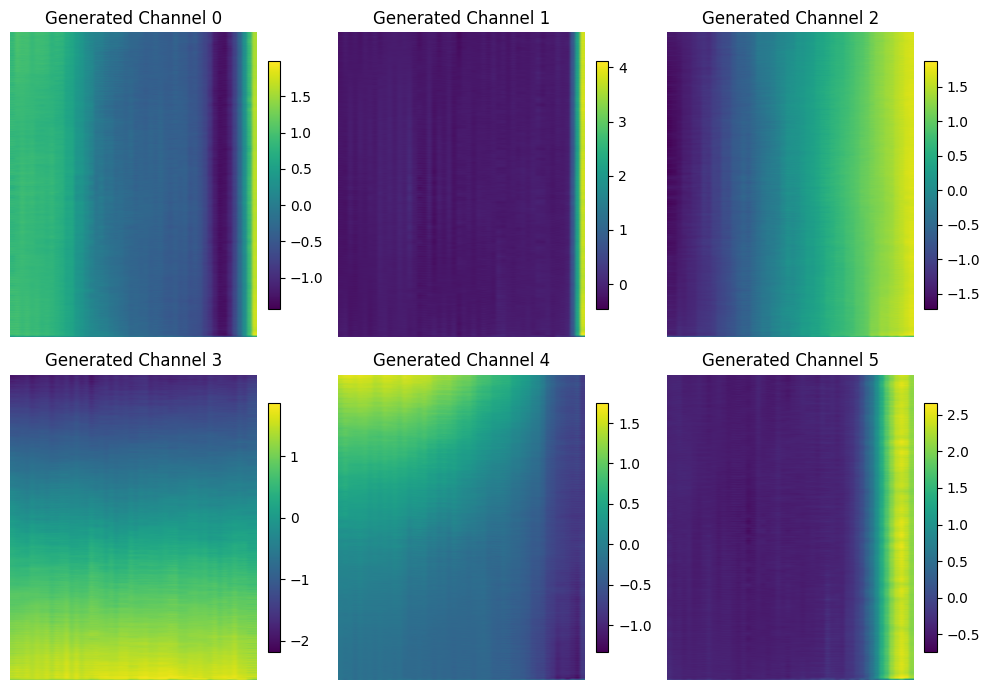

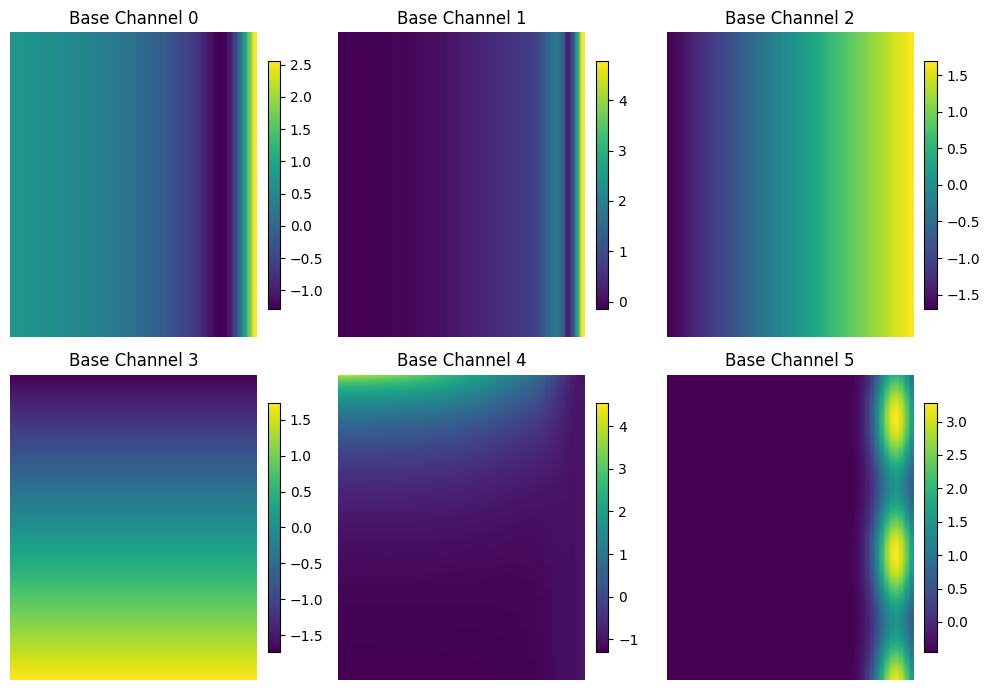

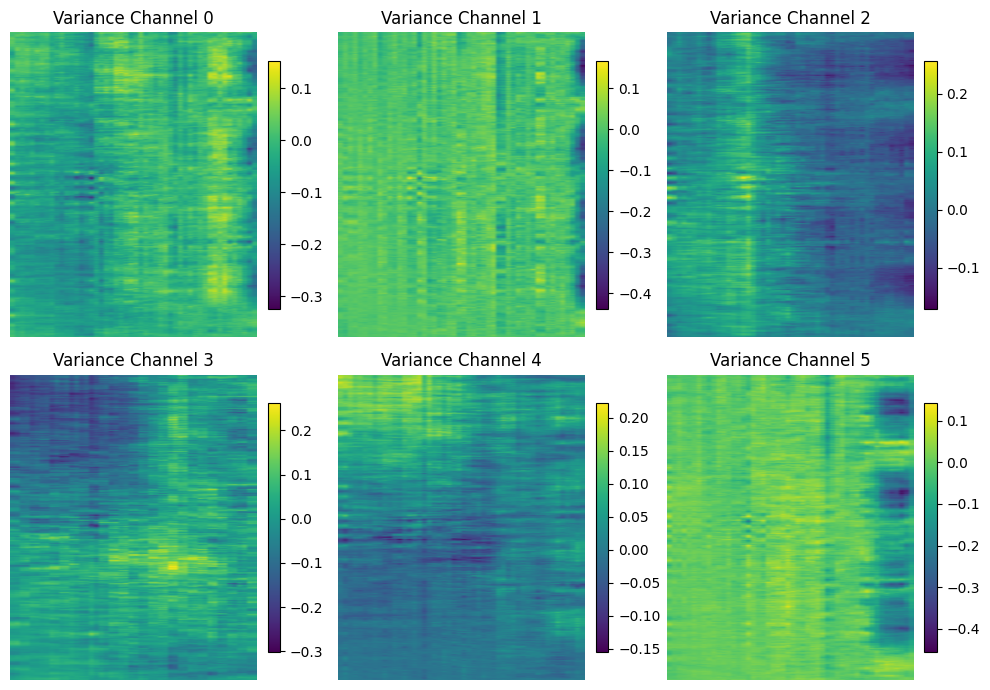

In [ ]:
import torch
import matplotlib.pyplot as plt

#Set the VAE to evaluation mode
vae.eval()

#Specify the latent dimension (should match what you used during training)
latent_dim = 640

#Sample a single latent vector from a standard normal distribution and decode it.
with torch.no_grad():
    z1 = torch.randn(1, latent_dim, device=device)  #Sample one latent vector
    z2 = torch.randn(1, latent_dim, device=device)  #Sample one latent vector
    generated1 = vae.decode(z1)
    generated2 = vae.decode(z2)

#Remove the batch dimension and move the tensor to CPU
sample1 = generated1.squeeze(0).cpu()
sample2 = generated2.squeeze(0).cpu()
sample1_np = sample1.numpy()
sample2_np = sample2.numpy()

#Plotting
fig, axs = plt.subplots(2, 3, figsize=(10,7))
axs = axs.ravel()
id_num = np.random.randint(10000)


for i in range(6):
    im = axs[i].imshow(sample1_np[i], aspect='auto', cmap='viridis')
    axs[i].set_title(f'Generated Channel {i}')
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

fig.savefig(f'GeneratedChannelsv{id_num}.png', dpi=300, bbox_inches='tight')
    
fig2, axs2 = plt.subplots(2, 3, figsize=(10,7))
axs2 = axs2.ravel()

for i in range(6):
    im = axs2[i].imshow(Database_channel_standardized[np.random.randint(1000)][i], aspect='auto', cmap='viridis')
    axs2[i].set_title(f'Base Channel {i}')
    axs2[i].axis('off')
    fig2.colorbar(im, ax=axs2[i], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

fig.savefig(f'BaseChannel{id_num}.png', dpi=300, bbox_inches='tight')

fig, axs = plt.subplots(2, 3, figsize=(10,7))
axs = axs.ravel()

for i in range(6):
    im = axs[i].imshow((sample1_np[i] - sample2_np[i]), aspect='auto', cmap='viridis')
    axs[i].set_title(f'Variance Channel {i}')
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

fig.savefig(f'VarianceChannel{id_num}.png', dpi=300, bbox_inches='tight')


In [ ]:
#Poolng, fix noise, etc.